# Predict future latency using LTSM
Haytham Mohamed - INFS890 - Spring 2020

In [438]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [439]:
input_dir = '../../../data/raw-data-linode-run3/merged/'     # this is prepared raw metrics signals
input_file = 'raw_timeseries_data.csv'

output_dir = input_dir 
model_checkpoint_file='model_checkpoint.keras'

log_dir = output_dir + 'model_logs/'


target = 'service_ltcy_200'

RUN_LSTM = True

SCALE_TARGET = False


In [440]:
metrics_df = pd.read_csv(input_dir + input_file)
metrics_df.head(3)

,date,service_ltcy_200,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage,time
0,2020-02-27 22:50:53,-0.014833,-1567.589522,-63164416.0,-6732.485102,-37926900.5,-101511168.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.0,82253.0
1,2020-02-27 22:50:54,-0.093383,2698.255249,78835712.0,0.000000,0.0,14336.0,10515.466667,-3.5,7.225067e+06,5.632048e+07,0.0,0.0,82254.0
2,2020-02-27 22:50:55,-0.093383,-45.337799,50089984.0,-223.979686,53967680.0,45056.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.0,82255.0


In [441]:
# move target column to the end 
cols = metrics_df.columns.tolist()
cols.insert(len(cols)-1, cols.pop(cols.index(target)))
metrics_df = metrics_df.reindex(columns= cols)

# index by date and sort
metrics_df.date = pd.to_datetime(metrics_df.date)
metrics_df.set_index('date', inplace=True)
metrics_df.sort_index()

metrics_df.head(3)

,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage,time,service_ltcy_200
date,,,,,,,,,,,,,
2020-02-27 22:50:53,-1567.589522,-63164416.0,-6732.485102,-37926900.5,-101511168.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.0,82253.0,-0.014833
2020-02-27 22:50:54,2698.255249,78835712.0,0.000000,0.0,14336.0,10515.466667,-3.5,7.225067e+06,5.632048e+07,0.0,0.0,82254.0,-0.093383
2020-02-27 22:50:55,-45.337799,50089984.0,-223.979686,53967680.0,45056.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.0,82255.0,-0.093383


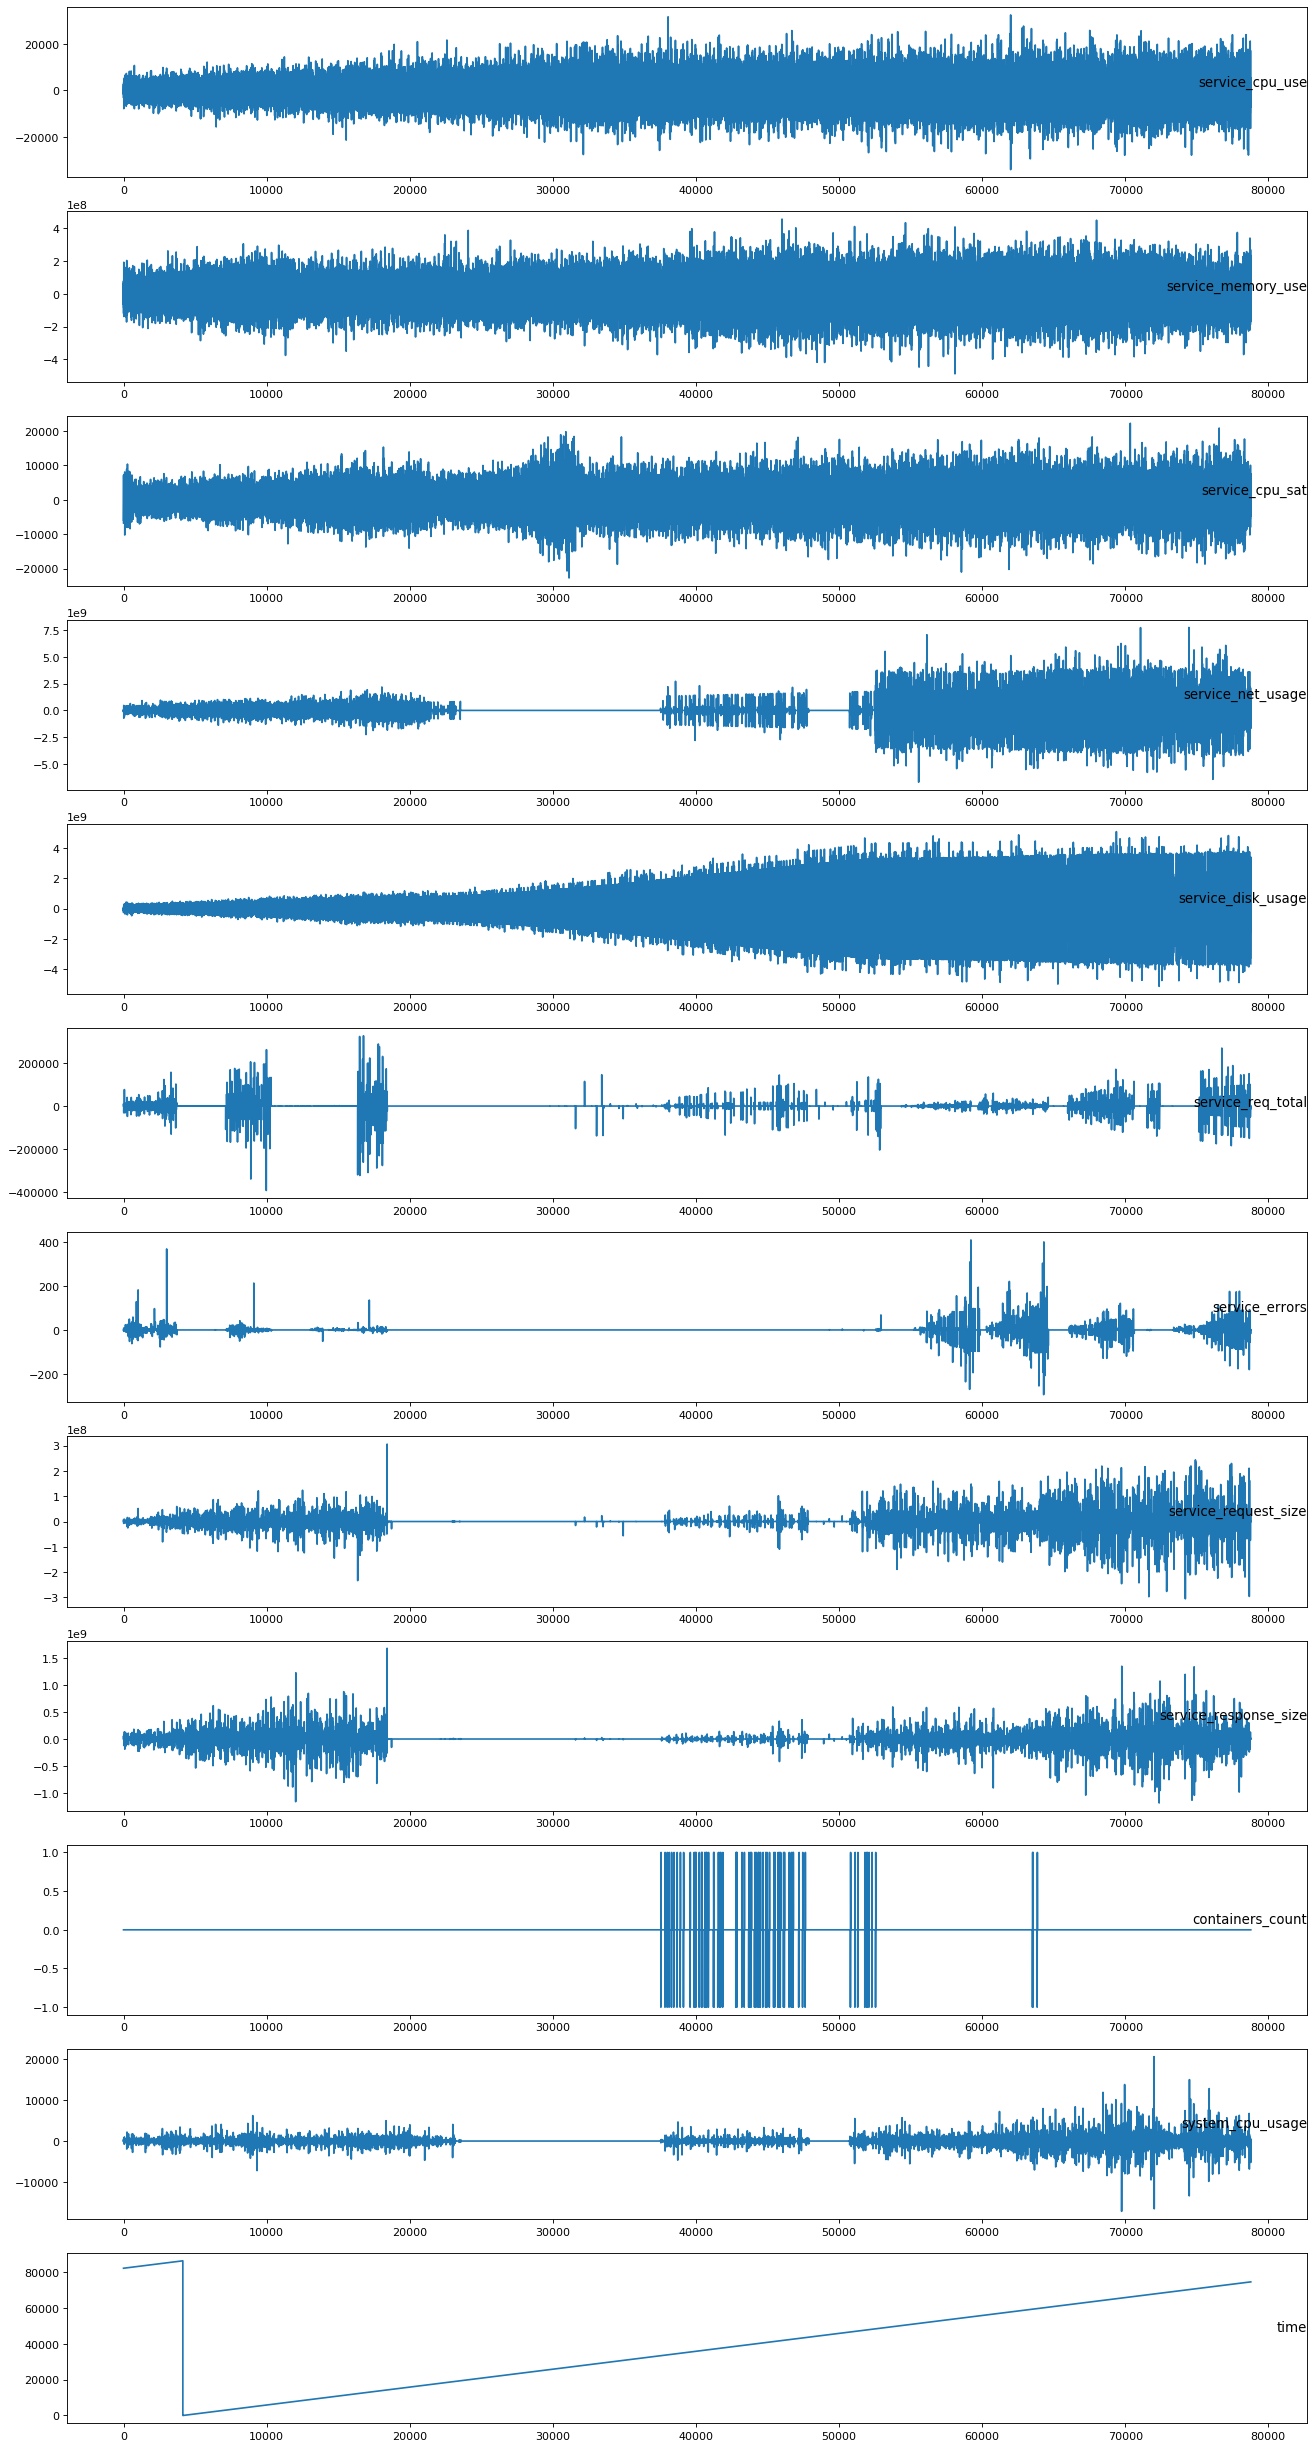

In [442]:
values = metrics_df.values
columns = metrics_df.columns

# specify columns to plot
number_of_features = len(columns) - 1

i = 1
## plot each column
plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')
for group in range(number_of_features):
    plt.subplot(number_of_features, 1, i)
    plt.plot(values[:, group])
    plt.title(columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# Target Data for Prediction

Assuming a 1 minute ahead prediction.

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation every 1 second, so there are 60 observations for every minute.

If we want to predict the latency 1 minute into the future, we shift the data 4 time-steps. If we want to predict the weather 2 minutes into the future, we shift the data 2 * 60 time-steps, and so on

In [443]:
shift_minutes = 1

shift_steps = shift_minutes * 60

In [444]:
# Target data series
df_targets = metrics_df[target].shift(-shift_steps)
df_targets.head(5)

date
2020-02-27 22:50:53    0.240639
2020-02-27 22:50:54    0.130501
2020-02-27 22:50:55    0.130501
2020-02-27 22:50:56    0.130501
2020-02-27 22:50:57    0.130501
Name: service_ltcy_200, dtype: float64

In [445]:
# double checking the shifted data
metrics_df[target].head(shift_steps + 5)  # before shifting. Note the 5th record shifted first

date
2020-02-27 22:50:53   -0.014833
2020-02-27 22:50:54   -0.093383
2020-02-27 22:50:55   -0.093383
2020-02-27 22:50:56   -0.093383
2020-02-27 22:50:57   -0.093383
                         ...   
2020-02-27 22:51:53    0.240639
2020-02-27 22:51:54    0.130501
2020-02-27 22:51:55    0.130501
2020-02-27 22:51:56    0.130501
2020-02-27 22:51:57    0.130501
Name: service_ltcy_200, Length: 65, dtype: float64

In [446]:
df_targets.tail()  # note last recrods are shifted up and no more values on them

date
2020-02-28 20:43:49   NaN
2020-02-28 20:43:50   NaN
2020-02-28 20:43:51   NaN
2020-02-28 20:43:52   NaN
2020-02-28 20:43:53   NaN
Name: service_ltcy_200, dtype: float64

# Data as Numpy Arrays

In [447]:
x_data = metrics_df[0:-shift_steps]
x_data = x_data.values
print("Shape x_data: ", x_data.shape)
print("type x_data: ", type(x_data))

y_data = df_targets.values[:-shift_steps]
y_data = y_data.reshape(-1,1)
print("Shape y_data: ", y_data.shape)
print("type y_data: ", type(y_data))

num_data = len(x_data)
print("There are {} sample data".format(num_data))

Shape x_data:  (78721, 13)
type x_data:  <class 'numpy.ndarray'>
Shape y_data:  (78721,)
type y_data:  <class 'numpy.ndarray'>
There are 78721 sample data


In [448]:
validate_split = 0.1
test_split = 0.1
train_split = 1 - (test_split + validate_split)

num_test = int(test_split * num_data)
num_validate = int(validate_split * num_data)
num_train = num_data - (num_test + num_validate)
print('Data splitted to training {} , validation {} and testing {}'.format(num_train, num_validate, num_test))

Data splitted to training 62977 , validation 7872 and testing 7872


In [449]:
x_train = x_data[:num_train]
x_validate = x_data[num_train:num_train+num_validate]
x_test = x_data[num_train+num_validate:]

len(x_train) + len(x_validate) + len(x_test)

78721

In [450]:
y_train = y_data[:num_train]
y_validate = y_data[num_train:num_train+num_validate]
y_test = y_data[num_train+num_validate:]

len(y_train) + len(y_validate) + len(y_test)

78721

In [451]:
x_validate

array([[ 2.91606049e+03,  4.00732160e+07, -4.35027189e+03, ...,
         0.00000000e+00,  5.88300000e+04, -2.11997287e-01],
       [-3.22192781e+03,  6.33436160e+07, -6.92750569e+03, ...,
         0.00000000e+00,  5.88310000e+04, -2.11997287e-01],
       [ 1.65220894e+04,  5.43760384e+07, -1.00750694e+03, ...,
         0.00000000e+00,  5.88320000e+04, -2.11997287e-01],
       ...,
       [-1.96761083e+04, -1.79614720e+08, -1.48575314e+03, ...,
         0.00000000e+00,  6.66990000e+04,  4.38386213e-01],
       [ 2.60858799e+03,  9.60433493e+07,  7.52645545e+02, ...,
         0.00000000e+00,  6.67000000e+04,  4.38386213e-01],
       [ 1.44553253e+03, -2.28655787e+07,  4.40975104e+03, ...,
        -1.80476354e+03,  6.67010000e+04,  4.38386213e-01]])

In [452]:
print('y_test shape {}'.format(y_test.shape))
y_test[0:10]

y_test shape (7872,)


array([-0.06909125, -0.06909125, -0.06909125, -0.06909125, -0.06909125,
       -0.06909125, -0.06909125, -0.06909125, -0.06909125, -0.06909125])

In [453]:
num_x_signals = x_data.shape[1]
num_x_signals

num_y_signals = y_data.shape[1]
num_y_signals

print('Experiment has {} number of features and {} number of target(s)'.format(num_x_signals,num_y_signals))


Experiment has 13 number of features and 78721 number of target(s)


## Scaled Data

In [454]:
print("Min:", np.min(x_train))
print("---------------------")
print("Max:", np.max(x_train))

Min: -6707571855.0
---------------------
Max: 7074885570.0


In [455]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_scaler = MinMaxScaler()  # StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_validate_scaled = x_scaler.transform(x_validate)
x_test_scaled = x_scaler.transform(x_test)

In [456]:
x_train_scaled

array([[0.48848374, 0.45017457, 0.37659363, ..., 0.50025128, 0.95201333,
        0.0745913 ],
       [0.55235796, 0.60022988, 0.53495631, ..., 0.50025128, 0.95202491,
        0.06864377],
       [0.51127703, 0.5698535 , 0.52968782, ..., 0.50025128, 0.95203648,
        0.06864377],
       ...,
       [0.56915356, 0.5324046 , 0.53495631, ..., 0.50025128, 0.68087594,
        0.05966272],
       [0.48284926, 0.22436012, 0.66174281, ..., 0.60487647, 0.68088751,
        0.05966272],
       [0.51010973, 0.54805268, 0.53495631, ..., 0.56269585, 0.68089908,
        0.05966272]])

In [457]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [458]:
if SCALE_TARGET:
    y_scaler =  MinMaxScaler() # StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_validate_scaled = y_scaler.transform(y_validate)
    y_test_scaled = y_scaler.transform(y_test)
else:
    y_train_scaled = y_train
    y_validate_scaled = y_validate
    y_test_scaled = y_test

Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

## Multivariate LSTM Forecast Model

We need to model a forecasting model that can predict set of metrics given past observed metrics. I will fit an LSTM model to the collected metrics data. 

Instead of training the Recurrent Neural Network on the complete sequences of all observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [459]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of sequence_length below.

In [460]:
# n number (of seconds) of samples in a batch. This equals to how far we want to predict, n number of seconds
batch_size = 300   # 5 minutes a head

A squence length is one batch of data for the machine to see at one step during the training. We will use a sequence-length for 15 minutes (quarter of an hour). In other words, each random sequence contains observations for 15 minutes. One time-step corresponds to 1 second, so 60 time-steps corresponds to 1 minute, and 0.25 x 60 x 60 corresponds to one quarter of an hour worth of observations.

In [461]:

sequence_hours = 0.25 
sequence_length = int(sequence_hours * 60 * 60)
sequence_length

900

create the batch-generator.

In [462]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [463]:
x_batch, y_batch = next(generator)

ValueError: could not broadcast input array from shape (900) into shape (900,78721)

This gives us a random batch of 246, each batch has 240 observations, and each observation has 13 input-signals and 1 output-signals.

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

We can plot one of the 20 input-signals as an example.

In [ ]:
batch = 0   # First sequence in the batch.
signal = 1  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 20 input signals.

In [ ]:
seq = y_batch[batch, :, 0]
plt.plot(seq)

# Validation and Testing Data

For the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [ ]:
test_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
validate_data = (np.expand_dims(x_validate_scaled, axis=0),
                   np.expand_dims(y_validate_scaled, axis=0))

# -----------------------------------------------

# LTSM Model


We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [ ]:
warmup_steps = 50

In [ ]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

Next, define and fit an LSTM model.

I will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 14 features.

In [ ]:
hidden_nodes_number_1 = 30
hidden_nodes_number_2 = 15
hidden_nodes_number_3 = 8

initialize=False

# design network
model = Sequential()


if initialize:
    from tensorflow.python.keras.initializers import RandomUniform
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model.add(LSTM(hidden_nodes_number_1, kernel_initializer=init, return_sequences=True, input_shape=(None, num_x_signals,)))
    #model.add(LSTM(hidden_nodes_number_1, kernel_initializer=init, return_sequences=True, activation='relu'))
    model.add(Dense(hidden_nodes_number_2, kernel_initializer=init, activation='relu'))
    model.add(Dense(hidden_nodes_number_3, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='linear'))
else:
    model.add(LSTM(hidden_nodes_number_1, kernel_initializer='normal', return_sequences=True, input_shape=(None, num_x_signals,)))
    #model.add(LSTM(hidden_nodes_number_1, kernel_initializer=init, return_sequences=True, activation='relu'))
    model.add(Dense(hidden_nodes_number_2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(hidden_nodes_number_3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))

#model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mean_squared_error', optimizer='adam')

#optimizer = RMSprop(lr=1e-3)
optimizer = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

model.summary()



# Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = output_dir + model_checkpoint_file
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [ ]:
callback_tensorboard = TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

# Train the Model

In [ ]:
%%time
epochs = 20
batch_size = 1000

steps_per_epoch = int(num_train / batch_size)   # = total number of training data points divided by the batch size

if RUN_LSTM:
    history = model.fit_generator(generator=generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validate_data,
                    callbacks=callbacks, verbose=1, shuffle=False)

In [ ]:
# plot history
if RUN_LSTM:
    plt.figure(figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

# Evaluate the Model

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))


In [ ]:

print("loss (test-set):", result)

In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

# Plot Prediction

In [ ]:
def y_comparison(start_idx, length=100, target_scaled=True, data_set='train'):
    """
    Obtain predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if data_set == 'train':
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    elif data_set == 'validate':
        x = x_validate_scaled
        y_true = y_validate
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    if target_scaled:
        # The output of the model is scaled.
        # Do an inverse map to get it back to the scale
        # of the original data-set.
        y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    else:
        y_pred_rescaled = y_pred[0]
    
    print("shape y_pred_rescaled: %", y_pred_rescaled.shape)
    print("shape y_true: %", y_true.shape)
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:]
        
    # Get the true output-signal from the data-set.
    signal_true = y_true[:]
    
    print("shape signal_pred: %", signal_pred.shape)
    print("shape signal_true: %", signal_true.shape)
    
    return signal_true, signal_pred


#This helper-function plots the predicted and true output-signals.
def plot_comparison(signal_true, signal_pred):
    """
    Plot the predicted and true output-signals.
    """

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
    # Plot labels etc.
    plt.ylabel('ltcy')
    plt.legend()
    plt.show()

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [ ]:
train_signal_true, train_signal_pred = y_comparison(start_idx=10, length=1000
                                                    , target_scaled=SCALE_TARGET, data_set='train')
plot_comparison(train_signal_true, train_signal_pred)

In [ ]:
train_signal_pred.reshape(-1,1000)

print('shape y test {}'.format(train_signal_true.shape))
print('shape y predicted {}'.format(train_signal_pred.shape))

print ("Actual train values: \n {}".format(train_signal_true[:20]))
print ("Predicted train values: \n {}".format(train_signal_pred[:20]))

print("")
# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_signal_true, train_signal_pred))
print('Train RMSE: %.3f' % rmse)

and from test

In [ ]:
test_signal_true, test_signal_pred = y_comparison(start_idx=10, length=1000
                                                    , target_scaled=SCALE_TARGET, data_set='test')
plot_comparison(test_signal_true, test_signal_pred)

## Evaluate Model

In [ ]:
print('shape y test {}'.format(test_signal_true.shape))
print('shape y predicted {}'.format(test_signal_pred.shape))

print ("Actual test values: \n {}".format(test_signal_true[:20]))
print ("Predicted test values: \n {}".format(test_signal_pred[:20]))

print("")
# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_signal_true, test_signal_pred))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# df['f'] = df['d'].rolling(2).sum().shift(-1)

print(test_signal_true.shape)
print(test_signal_pred.shape)

true_df = pd.DataFrame(test_signal_true)
pred_df = pd.DataFrame(test_signal_pred)


compare_df = pd.concat([true_df,pred_df], axis=1, sort=False, keys=['actual','predicted'])
compare_df.head(20)

